In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Statistics, Base.Threads, Plots, Graphs, IndexedGraphs, Random
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
import Measurements: value;

In [155]:
k = 5

J = 0.1    # coupling
β = 0.3  # inverse temperature
h = 0.01    # external field 
damp = 0.5;

In [156]:
m_eq = equilibrium_magnetization(RandomRegular(k), J; β, h, damp)

0.0035111727009080546

In [157]:
_, pij_parallel, m_eq_parallel = equilibrium_magnetization(RandomRegularParallel(k), J; β=β/2, 
    h, damp, Jself=100)
m_eq_parallel

0.0035111726026713086

In [158]:
m⁰ = 0.7  # magnetization at time zero
T = 30
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
N = 10^3
g = random_regular_graph(N, k)
spin(x) = 3-2x
rng = MersenneTwister(333)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, nv(g)), β)
bp = mpbp(Glauber(ising, T); ϕ=fill(ϕᵢ, N))
sms = SoftMarginSampler(bp);

In [159]:
sample!(sms, 10^3; showprogress=false);

In [160]:
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

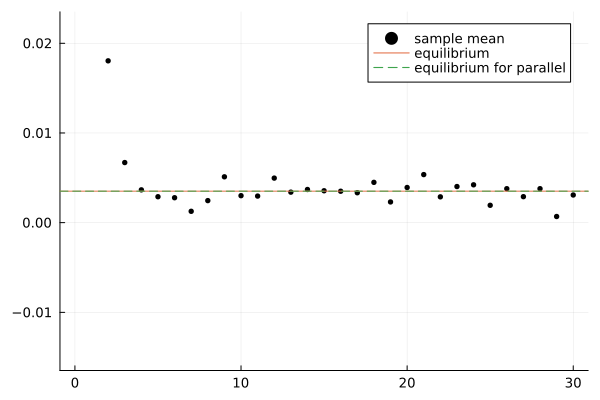

In [161]:
# pl = plot(0:T, m_mc, label=permutedims(["samples"; fill("", length(m_mc)-1)]), c=:gray, la=0.2)
pl = plot()
scatter!(pl, 0:T, mean(m_mc), c=:black, label="sample mean")
hline!(pl, [value(m_eq)], label="equilibrium", ls=:solid)
hline!(pl, [value(m_eq_parallel)], label="equilibrium for parallel", ls=:dash)
plot(pl, ylims=m_eq .+ 0.02.*(-1,1))

In [162]:
Js = 0:0.05:2
hs = 0.05:0.05:3

ms_eq = zeros(length(Js), length(hs))
ms_eq_parallel = zeros(length(Js), length(hs))

for i in eachindex(Js), j in eachindex(hs)
    ms_eq[i,j] = equilibrium_magnetization(RandomRegular(k), Js[i]; β, h=hs[j], damp)
    _, _, ms_eq_parallel[i,j] = equilibrium_magnetization(RandomRegularParallel(k), Js[i]; 
        β=β, h=hs[j], damp, init=[0.7 0.1; 0.1 0.1], maxiter=10^4)
end

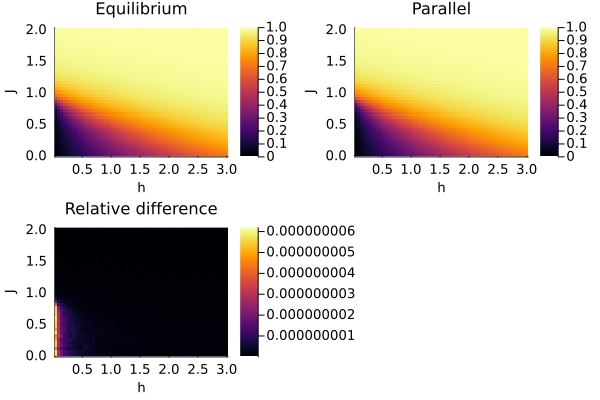

In [163]:
clims=(0,1)
xlabel="h"; ylabel="J"
plot(
    heatmap(hs, Js, ms_eq; clims, title="Equilibrium"),
    heatmap(hs, Js, ms_eq_parallel; clims, title="Parallel"),
    heatmap(hs, Js, abs.(ms_eq - ms_eq_parallel)./abs.(ms_eq); title="Relative difference");
    xlabel, ylabel)